In [1]:
import numpy as np 
from astropy.io import fits 
from astropy.convolution import Gaussian1DKernel, convolve
from matplotlib import pylab as plt
from astropy.stats import sigma_clip
import pandas as pd
from astropy import units as u
import numpy as np
from astropy.nddata import CCDData
import ccdproc
from scipy.ndimage import gaussian_filter1d
import os


In [2]:
#constants
gain = 1.2 #e/ADU
readnoise = 5 #e

### functions

In [3]:
def load_image(path, unit=u.adu, ext=1):
    """Open a FITS file and return a CCDData object."""
    with fits.open(path) as hdul:
        return CCDData(hdul[ext].data, unit=unit)

In [4]:
def plot_ccd_and_spectrum(data, window=[-5,5], figsize=(14,6), perc=5,
                          stdev=10, sigma_clipping=5, plot_smooth=True,
                          xlims_override=[], ylims_override=[], axvlines=[],
                          xlab='Wavelength [pix]', ylab='Signal', title=''):

    data = np.array(data)

    # Setup subplot
    fig, axs = plt.subplots(1, 2, figsize=figsize, gridspec_kw={'width_ratios': [1, 2]})

    # --- Left: 2D CCD plot
    axs[0].imshow(data, 
                  cmap='Spectral', 
                  origin='lower', 
                  aspect='auto',
                  vmin=np.nanpercentile(data, perc), 
                  vmax=np.nanpercentile(data, 100 - perc))
    axs[0].set_title("2D CCD Image")
    axs[0].set_xlabel('Position along slit [pix]')
    axs[0].set_ylabel('Wavelength [pix]')
    plt.colorbar(axs[0].images[0], ax=axs[0], fraction=0.046, pad=0.04)

    # --- Right: Extracted 1D Spectrum
    if len(data.shape) > 1:
        spectrum = extract_spectrum(data, window)
        xaxis = range(data.shape[0])[::-1]
    else:
        spectrum = data
        xaxis = range(len(data))[::-1]

    if isinstance(sigma_clipping, int):
        spectrum_clipped = sigma_clip(spectrum, sigma=sigma_clipping, maxiters=1)
    else:
        spectrum_clipped = spectrum
    smoothed = convolve(spectrum_clipped, Gaussian1DKernel(stddev=stdev))

    axs[1].plot(xaxis, spectrum_clipped, color='black', label='Raw')
    if plot_smooth:
        axs[1].plot(xaxis, smoothed, color='red', label='Smoothed')
    
    axs[1].set_xlabel(xlab)
    axs[1].set_ylabel(ylab)
    axs[1].set_title(title or "Extracted Spectrum")
    axs[1].legend()

    if ylims_override:
        axs[1].set_ylim(*ylims_override)
    else:
        axs[1].set_ylim(np.nanpercentile(spectrum_clipped, 1),
                        np.nanpercentile(spectrum_clipped, 100))

    if xlims_override:
        axs[1].set_xlim(*xlims_override)

    for axv in axvlines:
        axs[1].axvline(axv, color='r', linestyle='--', lw=1)

    plt.tight_layout()
    plt.show()


In [5]:
def plot_ccd(data,figsize = (7,12), perc = 5, axvlines = []):
    data = np.array(data)
    lam,slit = data.shape
    mid = slit/2
    
    plt.figure(figsize = figsize)

    plt.pcolormesh(data, vmin = np.nanpercentile(data,perc), vmax = np.nanpercentile(data,100-perc))
    plt.colorbar()
    plt.ylabel('Wavelength [pix]')
    plt.xlabel('Position along slit [pix]')
    plt.title('Raw data')
    
    for axv in axvlines:
        plt.axvline(mid+axv, c='r', lw = 1)

    plt.show()
    


In [6]:
def plot_estimated_spectrum(data,window = [-5,5],ylims_override = [],xlims_override = [], stdev = 10,
                            axvlines = [], figsize = (12,5), plot_smooth = True, sigma_clipping = 5, 
                            xaxis = [],xlab = 'Wavelength [pix]', ylab = 'Signal', title = '',
                           savefig = ''):
    data = np.array(data)
    
    if len(data.shape) > 1:
        gal = extract_spectrum(data,window)
        if xaxis == []:
            lam,slit = data.shape
            xaxis = range(lam)[::-1]
    else: #means spectrum already extracted
        gal = data
        if xaxis == []:
            xaxis = range(len(data))[::-1]
    
    if type(sigma_clipping) == int:
        galclip = sigma_clip(gal, sigma=sigma_clipping, maxiters=1) # Smooth the spectrum
    else:
        galclip = gal
    gauss = Gaussian1DKernel(stddev=stdev)
    galsmooth = convolve(galclip, gauss)
    
    plt.figure(figsize = figsize)
    plt.plot(xaxis,galclip,c='black')
    if plot_smooth:
        plt.plot(xaxis,galsmooth,c='r')
    
    plt.xlabel(xlab, fontsize = 16)
    plt.xticks(fontsize=14)
    plt.ylabel(ylab, fontsize = 16)
    plt.yticks(fontsize=14)
    plt.title(title, fontsize = 18)
    
    plt.ylim(np.nanpercentile(galclip,1),np.nanpercentile(galclip,100))
    if ylims_override != []:
        plt.ylim(ylims_override[0],ylims_override[1])
        
    if xlims_override != []:
        plt.xlim(xlims_override[0],xlims_override[1])
        
    for axv in axvlines:
        plt.axvline(axv, c='r', lw = 1, ls = '--')
    
    
    if savefig != '':
        plt.savefig(savefig,bbox_inches = 'tight',transparent=False,dpi=300,facecolor='white') 
    plt.show()

In [7]:
def extract_spectrum(data, window = [-5,5]):
    data = np.array(data)
    lam,slit = data.shape
    mid = slit/2
    gal = np.sum(data[:, int(mid+window[0]):int(mid+window[1])].astype(float), axis=1)/(window[1] - window[0]) # I would think to average, not sum? Guess it doesn't matter. y-axis just scales
    return gal


## SB_1

### raw data

In [8]:
raw_SB1 = '/Users/owner1/Documents/SURP/Data/INT 2023B/20231009/SB_1/parallel/r1688616.fit'

In [9]:
data = load_image(raw_SB1)

/Users/owner1/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:4737: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


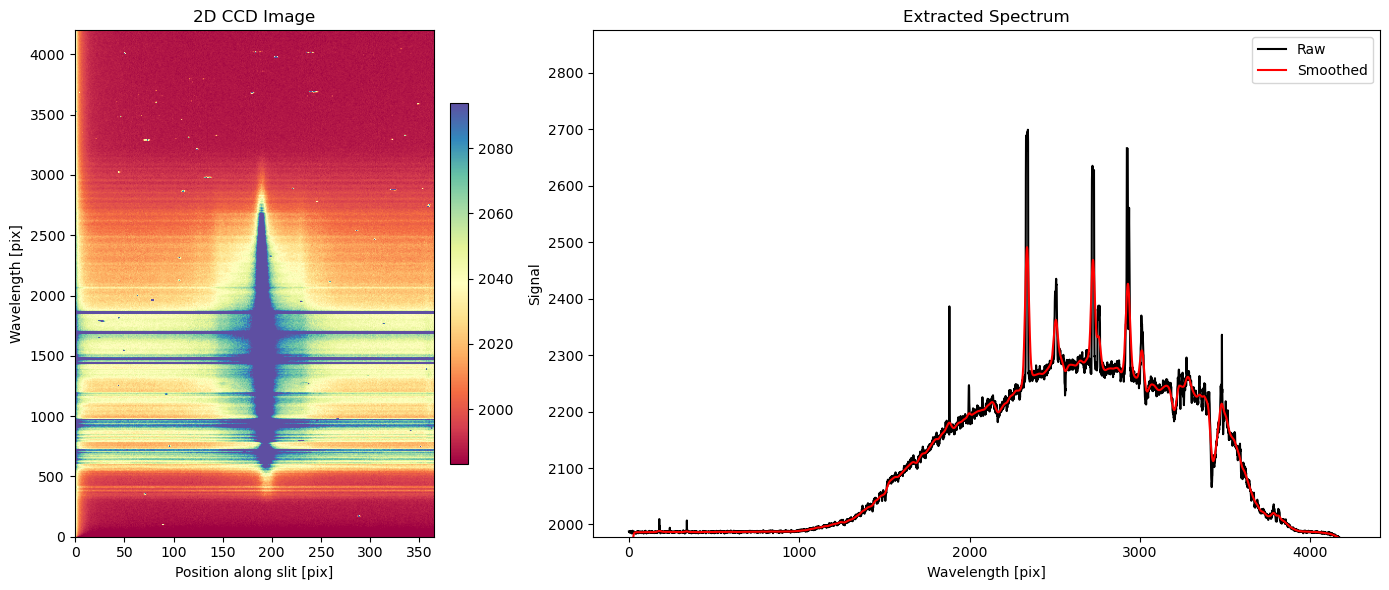

In [10]:
# Plot SB1
window = [5,13] 
plot_ccd_and_spectrum(data, window=window)

### apply uncertainty

/Users/owner1/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:4737: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


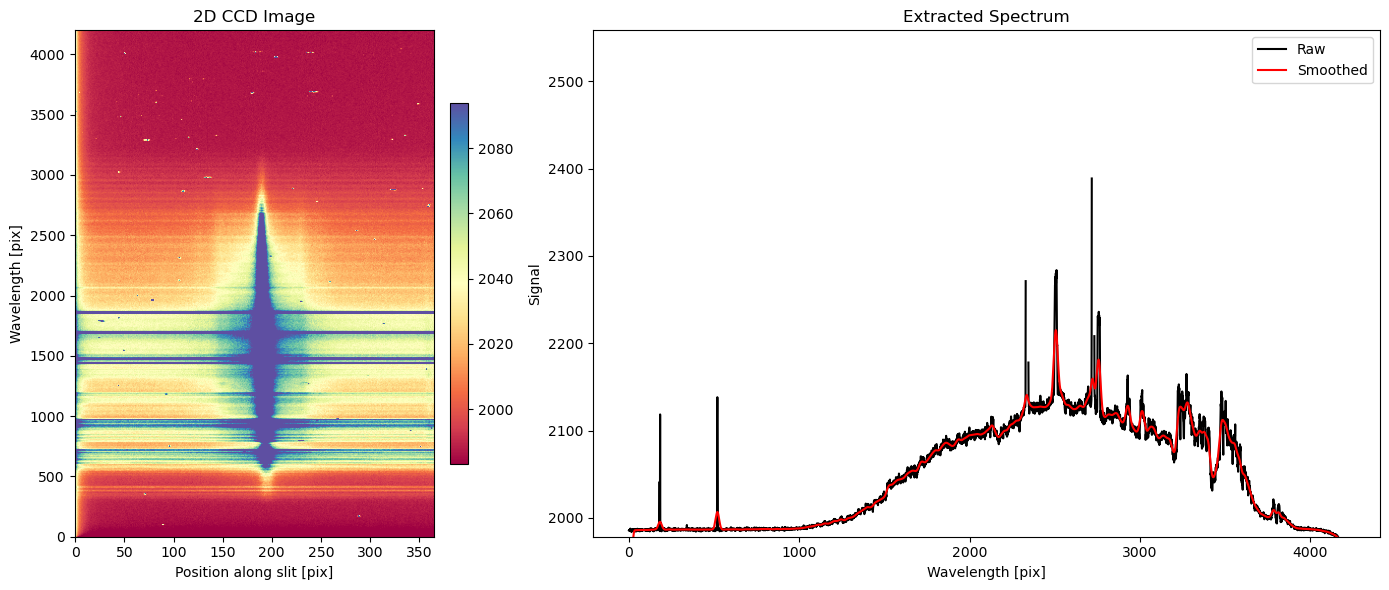

In [11]:
data = ccdproc.create_deviation(data,  # your CCDData object
    gain=gain * u.electron/u.adu,  # converts ADU to electrons
    readnoise=readnoise * u.electron)  # baseline CCD read noise)

plot_ccd_and_spectrum(data)

### gain correction

/Users/owner1/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:4737: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


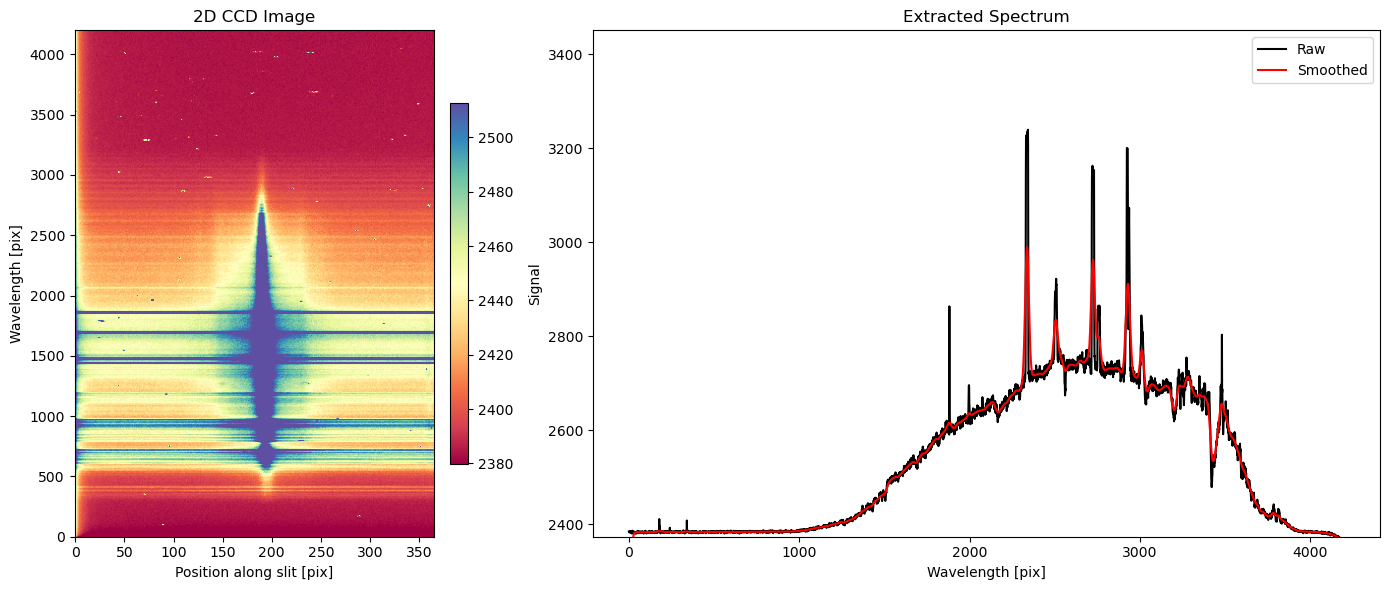

In [12]:
data = ccdproc.gain_correct(data, gain*u.electron/u.adu)
plot_ccd_and_spectrum(data, window = window)

### subtract overscan

In [13]:
data = ccdproc.subtract_overscan(data, median=True,  overscan_axis=0, overscan=data[4110:4190,:])

/Users/owner1/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:4737: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


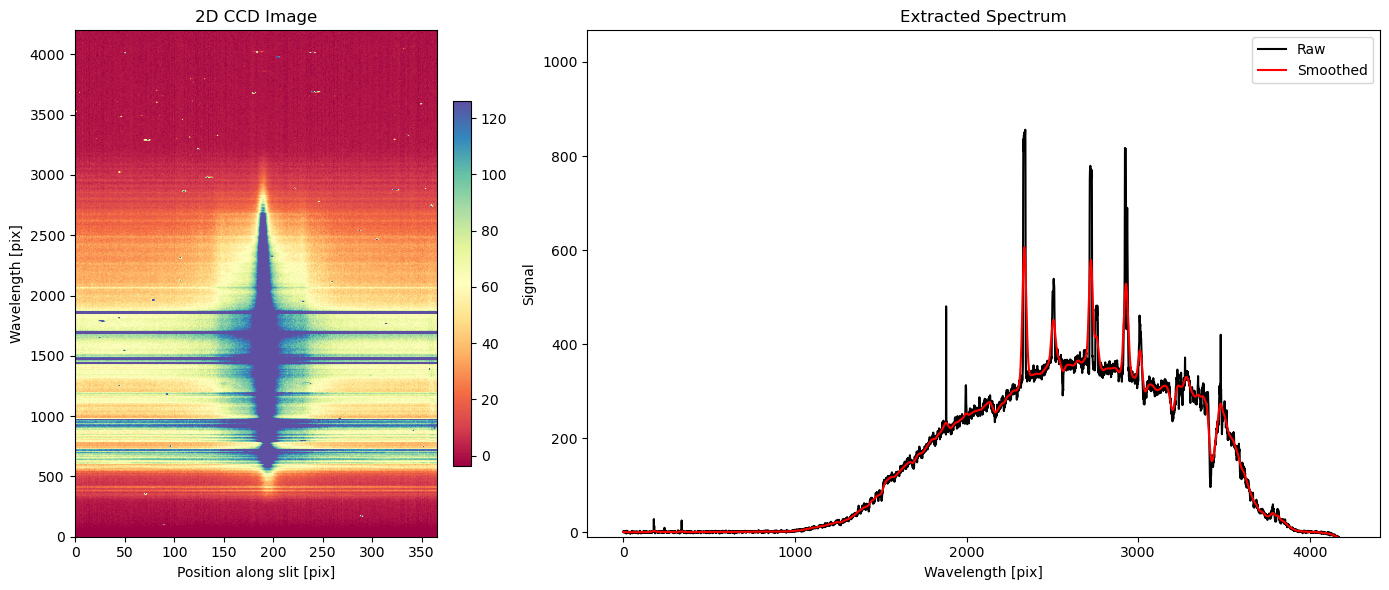

In [14]:
plot_ccd_and_spectrum(data, window=window)

### trim image

In [15]:
#data = ccdproc.trim_image(data[:4110, :])

In [16]:
#plot_ccd_and_spectrum(data, window = window)

### bias subtraction

In [17]:
bias_dir = '/Users/owner1/Documents/SURP/Data/INT 2023B/20231009/Bias'

bias_files = [os.path.join(bias_dir, f) for f in os.listdir(bias_dir)]

# Load data from each file
bias_arrays = [fits.getdata(f) for f in bias_files]

master_bias = np.mean(bias_arrays, axis=0)

In [18]:
master_bias = CCDData(master_bias, unit=u.adu)
master_bias = ccdproc.gain_correct(master_bias, gain*u.electron/u.adu)
master_bias = ccdproc.subtract_overscan(master_bias, median=True,  overscan_axis=0, overscan=master_bias[4110:4190,:])
#master_bias = ccdproc.trim_image(master_bias[:4110, :])

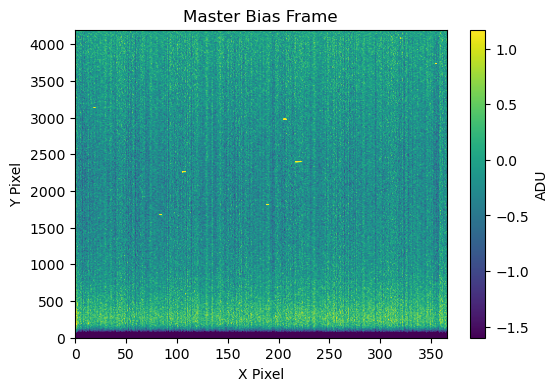

In [19]:
#check what the master bias looks like
plt.figure(figsize=(6,4))  
plt.imshow(master_bias.data, cmap='viridis', origin='lower',
           vmin=np.percentile(master_bias.data, 5),
           vmax=np.percentile(master_bias.data, 95),
           aspect='auto') 
plt.colorbar(label='ADU')
plt.xlabel('X Pixel')
plt.ylabel('Y Pixel')
plt.title('Master Bias Frame')
plt.show()


In [20]:
print(data.unit)   # Should be 'adu' or 'electron'
print(master_bias.unit) 
print(master_bias.shape)

electron
electron
(4200, 366)


In [21]:
data_bg_subtracted = ccdproc.subtract_bias(data, master_bias)

In [22]:
print(np.mean(master_bias.data))

-0.2689208207872684


In [23]:
mean_before = np.mean(data.data)
std_before = np.std(data.data)
print(f"Background mean before bias subtraction: {mean_before:.2f} ADU")
print(f"Background standard before after bias subtraction: {std_before:.2f} ADU")

Background mean before bias subtraction: 42.32 ADU
Background standard before after bias subtraction: 68.63 ADU


In [24]:
mean_bg = np.mean(data_bg_subtracted.data)
std_bg = np.std(data_bg_subtracted.data)
print(f"Background mean after bias subtraction: {mean_bg:.2f} ADU")
print(f"Background standard deviation after bias subtraction: {std_bg:.2f} ADU")

Background mean after bias subtraction: 42.59 ADU
Background standard deviation after bias subtraction: 68.57 ADU


In [25]:
plot_ccd_and_spectrum(data_bg_subtracted, window = window)

/Users/owner1/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:4737: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


### flatfield correction

In [26]:
flat_path = '/Users/owner1/Documents/SURP/Data/INT 2023B/20231009/flat-field/'

flat_files = [os.path.join(flat_path, f'r16886{i:02d}.fit')
              for i in range(62, 73)]
    
flats = [load_image(f) for f in flat_files]

master_flat_data = np.median([f.data for f in flats], axis=0)
master_flat = CCDData(master_flat_data, unit=u.adu)

In [27]:
master_flat = ccdproc.create_deviation(master_flat, gain=gain * u.electron/u.adu,readnoise = readnoise * u.electron)
master_flat = ccdproc.gain_correct(master_flat, gain*u.electron/u.adu)
master_flat = ccdproc.subtract_overscan(master_flat, median=True,  overscan_axis=0, overscan=master_flat[4110:4190,:])
master_flat = ccdproc.subtract_bias(master_flat, master_bias) 

In [28]:
print(master_flat.unit)   # Should be 'adu' or 'electron'
print(master_bias.unit)   # Should match!

electron
electron


In [29]:
# Collapse the flat across the spatial direction
profile = np.mean(master_flat.data, axis=1)

# Smooth with Gaussian
smoothed = convolve(profile, Gaussian1DKernel(stddev=20))

# Plot
plt.figure(figsize=(8, 4))
plt.plot(profile, label='Original')
plt.plot(smoothed, label='Smoothed', linestyle='--')
plt.xlabel('Wavelength [pix]')
plt.ylabel('Average Signal')
plt.title('Flat Field Profile')
plt.legend()
plt.tight_layout()
plt.show()


In [30]:
#Normalize the master flat
master_flat = ((np.array(master_flat).T / smoothed)).T
master_flat = master_flat / np.mean(master_flat)
master_flat = CCDData(master_flat, unit=u.electron)

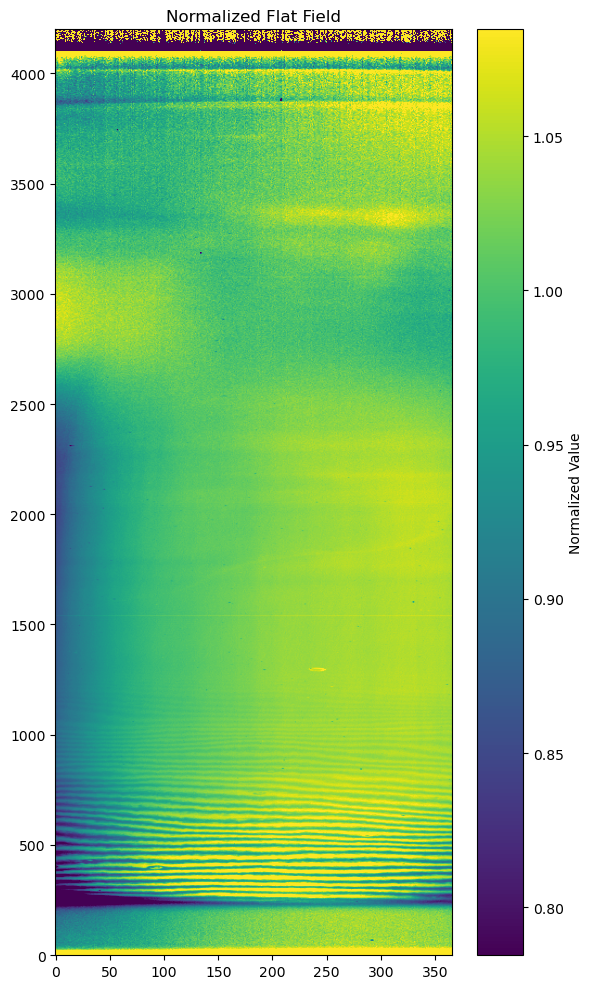

In [31]:
#Visualize the flat
plt.figure(figsize=(6, 10))
plt.imshow(master_flat.data, origin='lower', aspect='auto',
           vmin=np.percentile(master_flat.data, 2),
           vmax=np.percentile(master_flat.data, 95),
           cmap='viridis')
plt.colorbar(label='Normalized Value')
plt.title('Normalized Flat Field')
plt.tight_layout()
plt.show()


In [32]:
# Apply flatfield
data = ccdproc.flat_correct(data_bg_subtracted, master_flat, min_value=0.01)

plot_ccd_and_spectrum(data, window = window)


/Users/owner1/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:4737: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


### Sky Subtraction

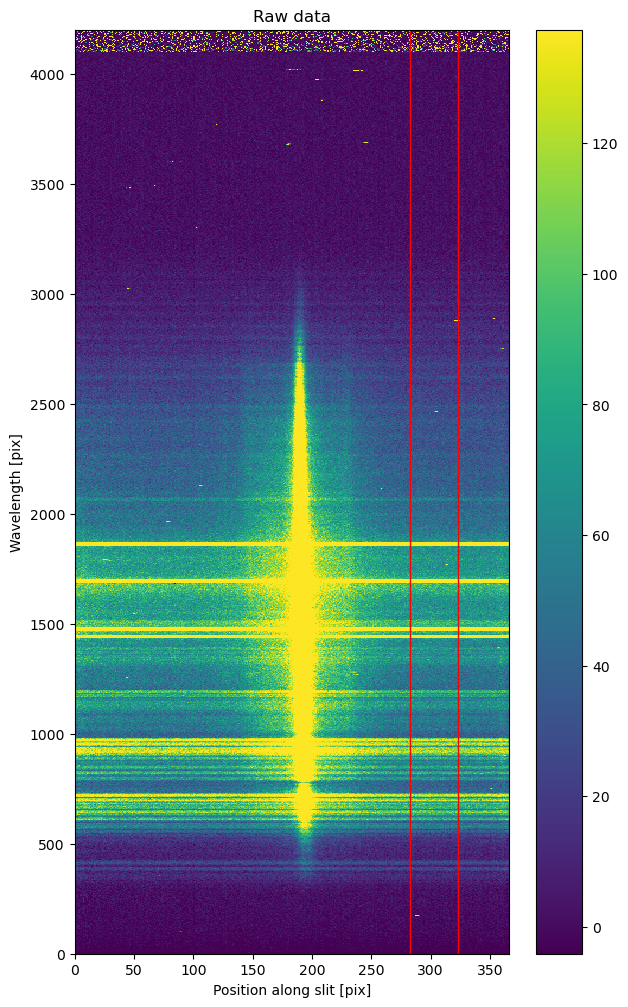

In [33]:
sky_window = [100,140] #selection window for sky subtraction

plot_ccd(data, axvlines = sky_window)

lam,slit = data.shape
mid = slit/2
sky = data[:,int(mid+sky_window[0]):int(mid+sky_window[1])]
sky = np.median(sky,axis = 1)

plt.figure(figsize = (12,5))
plt.plot(range(len(sky))[::-1],sky)
plt.xlabel('Wavelength [pix]')
plt.ylabel('Signal')
plt.title('Sky signal')
plt.show()


In [34]:
# Apply sky subtraction
data = np.array(data)[:4000, :] 
sky = sky[:4000]
data = (np.array(data).T - np.array(sky)).T
data = CCDData(data, unit=u.electron)

plot_ccd_and_spectrum(data, window = window )


/Users/owner1/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:4737: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


### Normalisation / Blaze Correction

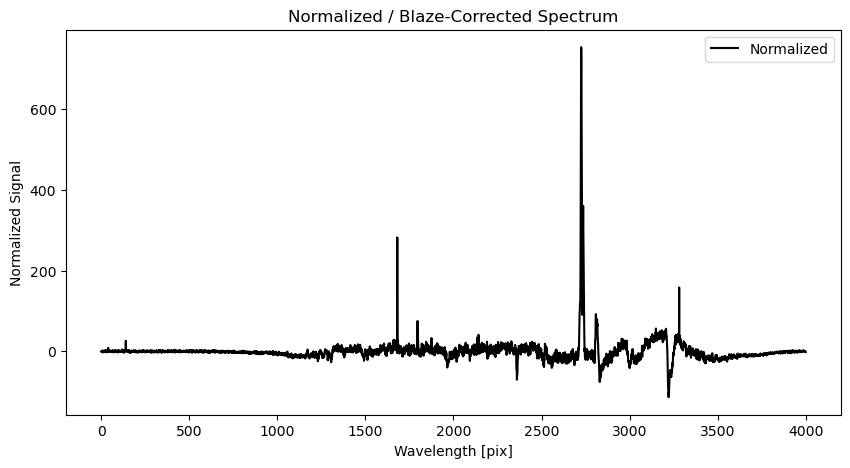

In [35]:
spectrum = extract_spectrum(data,window)
stdev = 150
gauss = Gaussian1DKernel(stddev=stdev)
blaze = convolve(spectrum, gauss)
spectrum = spectrum - blaze

plt.figure(figsize=(10,5))
plt.plot(range(len(spectrum))[::-1], spectrum, color='black', label='Normalized')
plt.xlabel('Wavelength [pix]')
plt.ylabel('Normalized Signal')
plt.title('Normalized / Blaze-Corrected Spectrum')
plt.legend()
plt.show()

### Apply Arcs

In [36]:
short_arc_path = '/Users/owner1/Documents/SURP/Data/INT 2023B/20231009/Arc/r1688650.fit'

arc = load_image(short_arc_path)

arc = CCDData(arc, unit=u.adu)

INFO:astropy:overwriting NDData's current unit with specified unit.


INFO: overwriting NDData's current unit with specified unit. [astropy.nddata.nddata]


In [37]:
print(master_bias.unit)
master_bias = CCDData(master_bias.data[:4000, :], unit=master_bias.unit)


electron


In [38]:
arc = ccdproc.create_deviation(arc, gain=gain * u.electron/u.adu,readnoise = readnoise * u.electron)
arc = ccdproc.gain_correct(arc, gain*u.electron/u.adu)
arc = ccdproc.subtract_overscan(arc, median=True,  overscan_axis=0, overscan=arc[4110:4190,:])
arc = ccdproc.trim_image(arc[:4000,:])
arc = ccdproc.subtract_bias(arc, master_bias) 

In [39]:
plot_estimated_spectrum(arc, window = window,ylims_override = [0,80000], 
                        plot_smooth = False, figsize = (12,6),
                       sigma_clipping = False, xlims_override=(2000, 3800))

In [40]:
from scipy.signal import find_peaks
arc_spectrum = extract_spectrum(arc, window)
peaks, _ = find_peaks(arc_spectrum, height=8000, distance = 15)

In [41]:
plt.figure(figsize=(10,5))
xaxis = np.array(range(len(arc_spectrum)))[::-1]

plt.plot(xaxis, arc_spectrum, label='Arc Spectrum')
plt.plot(xaxis[peaks], arc_spectrum[peaks], 'rx', label='Detected Peaks')
plt.xlabel('Wavelength [pix]')
plt.ylabel('Signal')
plt.title('Arc Spectrum with Detected Peaks')
plt.xlim(2000,3800)
plt.legend()
plt.show()


In [42]:
def centroid(x, I):
    value= np.sum(x*I)/np.sum(I)
    return value 

In [43]:
# Define window range
ranges = 8

# Compute centroids
centroids = []
for i in range(len(peaks)):
    left = max(peaks[i] - ranges, 0)
    right = min(peaks[i] + ranges + 1, len(arc_spectrum))
    window_x = xaxis[left:right]
    window_y = arc_spectrum[left:right]
    
    # Calculate centroid as weighted average
    centroid = np.sum(window_x * window_y) / np.sum(window_y)
    centroids.append(centroid)

print("Centroid positions:", centroids)

Centroid positions: [3236.4349508013306, 3165.9020623074243, 3132.83358760207, 3028.1944353846843, 2990.2336037439736, 2914.524008982781, 2859.6183648752535, 2745.495039638304, 2725.67749208829, 2684.945795417731, 2639.816004435203, 2574.1271618353458, 2540.0164387257405, 2506.0164511223993, 2481.082499198423, 2443.6838570304353, 2409.260995996824, 2336.6523462279592, 2302.1979443798778, 2287.114960718597]


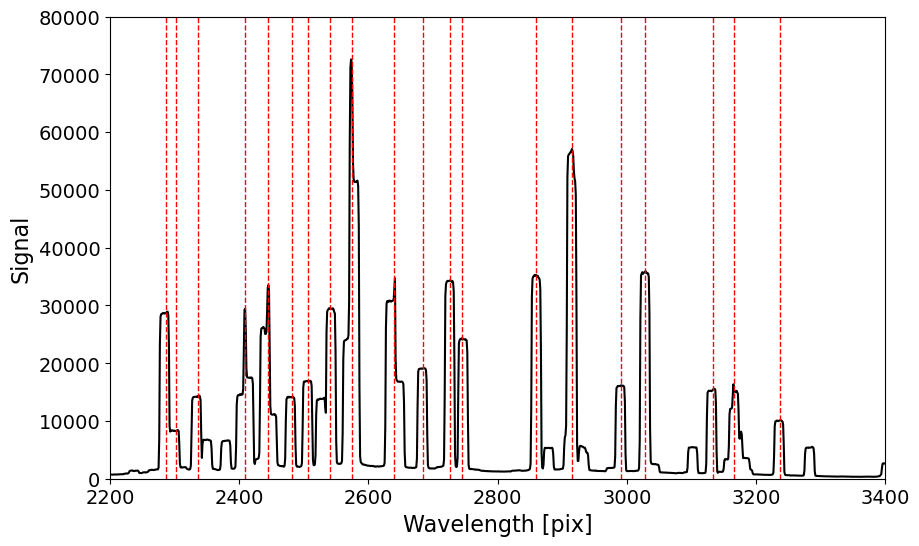

In [44]:
plot_estimated_spectrum(arc, window = window,ylims_override = [0,80000], 
                        plot_smooth = False, figsize = (10,6),
                       sigma_clipping = False, xlims_override=(2200, 3400), axvlines = centroids)

In [45]:
# Known emission lines
emissions = np.array([5852.49, 5881.90, 5944.83, 6096.16, 6143.06, 
                      6217.28, 6266.50, 6334.43, 6402.25, 6506.53,
                      6598.95, 6678.28, 6717.04, 6929.47, 7032.41, 
                      7173.94, 7245.17, 7438.90, 7503.87, 7635.11])

# Measured pixel centroids
centroids = np.array(sorted(centroids))  

# Fit a line (degree=1)
coeffs = np.polyfit(centroids, emissions, 1)
slope, intercept = coeffs

print(f"Slope: {slope:.5f} Å/pixel")
print(f"Intercept: {intercept:.5f} Å")

# Evaluate the fit
fitted_wavelengths = slope * centroids + intercept

# Plotting
plt.figure(figsize=(8,6))
plt.plot(centroids, emissions, 'bo', label='Known Lines')
plt.plot(centroids, fitted_wavelengths, 'r-', label='Linear Fit')
plt.xlabel('Pixel Position')
plt.ylabel('Wavelength (Å)')
plt.title('Wavelength Calibration')
plt.legend()
plt.show()


Slope: 1.87502 Å/pixel
Intercept: 1567.00778 Å


In [46]:
# Pixels for the spectrum
pixels = np.arange(len(arc_spectrum))[::-1]

# Apply the linear calibration
xaxis_waveobs = slope * pixels + intercept

# Apply redshift correction
redshift = 0.0427842
xaxis_waveem = xaxis_waveobs / (1 + redshift)

In [47]:
plot_estimated_spectrum(spectrum, window = window, xaxis = xaxis_waveem, ylims_override=[-150,300],
                        figsize = (20,5), xlab = r'Wavelength [$\AA$]', ylab = r'Signal',
                        sigma_clipping = 10, stdev = 10)

/var/folders/r3/l94405xd0mq2s62v2swzjq2m0000gn/T/ipykernel_19742/317215241.py:14: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if xaxis == []:
/Users/owner1/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:4737: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
